In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import itertools

In [2]:
def plot_confusion_matrix(cm, classes, title):
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    plt.grid(False)

### Loading in the data with the desired features

Data (along with labels) can be found here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910/DVN/GDF6Z0

In [3]:
cols = ['gender', 'birthyr', 'educ', 'race', 'countyfips', 'pew_religimp', 'newsint', 'CC16_351I', 'CC16_302', 'CC16_331_7', 'CC16_330d', 'CC16_332a', 'CC16_351K', 'CC16_335', 'CC16_364c']
df = pd.read_csv('data/CCES16_Common_OUTPUT_Feb2018_VV.tab', sep='\t', header=0, usecols=cols)[cols]
df = df[(df.CC16_364c == 1.0) | (df.CC16_364c == 2.0)] # getting only the people who preferred Trump, Clinton, or weren't sure
df = df.dropna().astype(int).rename(columns={'birthyr': 'age', 'countyfips': 'state'})
df.age = 2016 - df.age
df['state'] = df['state'].map(lambda x: f'{x:05}'[:2]) # converting county fips to state ID string

In [4]:
df.head()

,gender,age,educ,race,state,pew_religimp,newsint,CC16_351I,CC16_302,CC16_331_7,CC16_330d,CC16_332a,CC16_351K,CC16_335,CC16_364c
0,2,47,2,1,33,2,2,1,3,1,2,1,1,1,1
2,2,52,2,2,29,1,2,1,5,2,1,2,1,1,2
4,2,34,5,1,08,4,1,2,2,2,1,2,1,1,2
5,2,53,2,6,01,1,3,1,4,1,1,1,1,1,2
6,1,54,2,1,48,1,1,1,3,1,2,2,1,2,1


### Verifying that there are no "skipped" responses, crosschecked to the data source

In [5]:
features = df.columns.tolist()
features.remove('age')
features.remove('state')
for feature in features:
    print(f'{feature} : {df[feature].unique()}')

gender : [2 1]
educ : [2 5 3 6 4 1]
race : [1 2 6 4 3 5 7 8]
pew_religimp : [2 1 4 3]
newsint : [2 1 3 7 4]
CC16_351I : [1 2]
CC16_302 : [3 5 2 4 6 1]
CC16_331_7 : [1 2]
CC16_330d : [2 1]
CC16_332a : [1 2]
CC16_351K : [1 2]
CC16_335 : [1 2]
CC16_364c : [1 2]


### Verifying that there are no highly correlated features

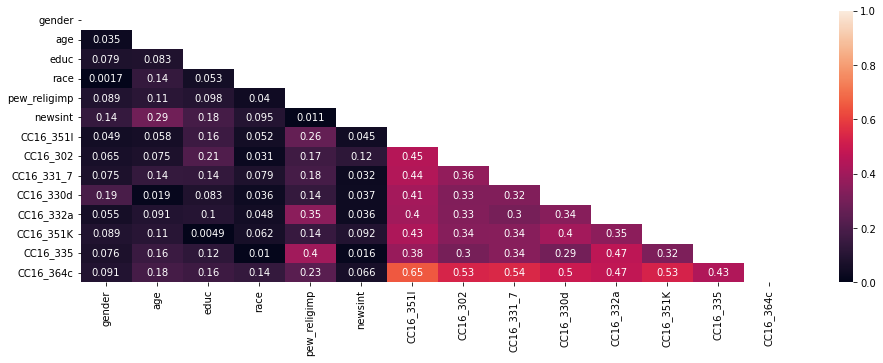

In [6]:
plt.figure(figsize=(16, 5))
corr = df.corr().abs()
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)
corr = corr.where(cond=mask)
sns.heatmap(corr, annot=True, vmin=0, vmax=1);

### splitting the data evenly by party

In [7]:
def sampling_k_elements(group, k=min(df.CC16_364c.value_counts())):
    if len(group) < k:
        return group
    return group.sample(k)

df = df.groupby('CC16_364c').apply(sampling_k_elements).reset_index(drop=True)

In [8]:
train, test = train_test_split(df, stratify=df.CC16_364c, test_size=0.3, random_state=42)
data_train, data_eval, label_train, label_eval = train_test_split(train.drop('CC16_364c', axis=1), train.CC16_364c, stratify=train.CC16_364c, test_size=0.3, random_state=42)
data_test, label_test = test.drop('CC16_364c', axis=1), test.CC16_364c

In [9]:
label_train.value_counts(), label_eval.value_counts(), label_test.value_counts()

(2    9194
 1    9193
 Name: CC16_364c, dtype: int64,
 1    3941
 2    3940
 Name: CC16_364c, dtype: int64,
 1    5629
 2    5629
 Name: CC16_364c, dtype: int64)

### Makin/Training the model

In [10]:
categorical_features_indices = np.where(train.dtypes != int)[0]

In [11]:
classifier = CatBoostClassifier(iterations=1000, depth=3, learning_rate=0.05, loss_function='Logloss', eval_metric='Accuracy')
classifier.fit(data_train, label_train, cat_features=categorical_features_indices, eval_set=(data_eval, label_eval), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8565291	test: 0.8568710	best: 0.8568710 (0)	total: 212ms	remaining: 3m 32s
1:	learn: 0.8730081	test: 0.8726050	best: 0.8726050 (1)	total: 229ms	remaining: 1m 54s
2:	learn: 0.8710502	test: 0.8691790	best: 0.8726050 (1)	total: 246ms	remaining: 1m 21s
3:	learn: 0.8579975	test: 0.8569978	best: 0.8726050 (1)	total: 262ms	remaining: 1m 5s
4:	learn: 0.8544080	test: 0.8538257	best: 0.8726050 (1)	total: 278ms	remaining: 55.3s
5:	learn: 0.8710502	test: 0.8691790	best: 0.8726050 (1)	total: 295ms	remaining: 48.8s
6:	learn: 0.8719204	test: 0.8701941	best: 0.8726050 (1)	total: 310ms	remaining: 44s
7:	learn: 0.8719204	test: 0.8701941	best: 0.8726050 (1)	total: 326ms	remaining: 40.5s
8:	learn: 0.8703432	test: 0.8682908	best: 0.8726050 (1)	total: 342ms	remaining: 37.6s
9:	learn: 0.8678414	test: 0.8661337	best: 0.8726050 (1)	total: 357ms	remaining: 35.3s
10:	learn: 0.8660467	test: 0.8643573	best: 0.8726050 (1)	total: 372ms	remaining: 33.5s
11:	learn: 0.8723011	test: 0.8699404	best: 0.8726050

### Model Performance

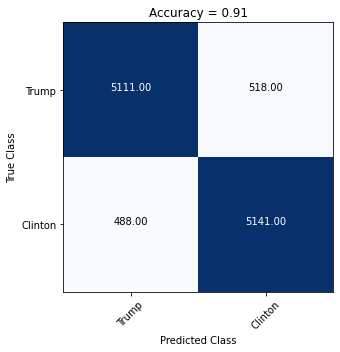

In [12]:
preds = classifier.predict(data_test)
cm = confusion_matrix(label_test, preds, labels=[1, 2])
plot_confusion_matrix(cm, ['Trump', 'Clinton'], f'Accuracy = {np.round(classifier.score(data_test, label_test), 2)}')

In [13]:
classifier.save_model("catboost_classifier")